### In this code is written for research environment in Quantconnect. I have modified the SVM Wavelet Forecasting sterategy that implemented by Quantconnect team in the following page:

"https://www.quantconnect.com/explore/14987999/SVM-Wavelet-Forecasting" 

### I have used LSTM instead of SVM to train the model and also developed dynamic threshold for wavelet denoising block. 

In [ ]:
from AlgorithmImports import *
import numpy as np
import pandas as pd
import pywt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# --- Parameters ---
symbol = Symbol.Create("EURUSD", SecurityType.Forex, Market.Oanda)
lookback = 50
window_size = 150
resolution = Resolution.Hour

# --- Get Historical Data ---
history_df = qb.History(symbol, window_size + lookback + 2, resolution)

if history_df.empty or 'close' not in history_df.columns:
    raise ValueError("Historical data not retrieved properly.")

# --- Extract Prices ---
prices = history_df['close'].dropna().values
prices = prices[-(window_size + lookback):]

# --- Wavelet Denoising ---
def wavelet_denoise(signal, wavelet='sym10', level=2):
    coeffs = pywt.wavedec(signal, wavelet, mode="periodic", level=level)
    sigma = (1/0.6745) * np.median(np.abs(coeffs[-level]))
    uthresh = sigma * np.sqrt(2 * np.log(len(signal)))
    denoised_coeffs = [pywt.threshold(c, value=uthresh, mode='soft') if i > 0 else c for i, c in enumerate(coeffs)]
    return pywt.waverec(denoised_coeffs, wavelet, mode='periodic')[:len(signal)]

denoised_prices = wavelet_denoise(prices)

# --- Normalize ---
scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(denoised_prices.reshape(-1, 1))

# --- Prepare LSTM Data ---
X = []
y = []
for i in range(lookback, len(scaled_prices)):
    X.append(scaled_prices[i - lookback:i, 0])
    y.append(scaled_prices[i, 0])
X = np.array(X)
y = np.array(y)
X = X.reshape((X.shape[0], X.shape[1], 1))

# --- Split into Train/Test ---
split_ratio = 0.8
split_index = int(len(X) * split_ratio)
X_train, y_train = X[:split_index], y[:split_index]
X_test, y_test = X[split_index:], y[split_index:]

# --- Build and Train LSTM Model ---
model = Sequential([
    LSTM(units=128, return_sequences=False, input_shape=(X.shape[1], 1)),
    Dense(units=1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)

# --- Predict on Test Set ---
y_pred_scaled = model.predict(X_test, verbose=0)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test.reshape(-1, 1))

# --- Evaluation Metrics ---
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

# --- Directional Accuracy ---
true_diff = np.sign(np.diff(y_true.flatten()))
pred_diff = np.sign(np.diff(y_pred.flatten()))
directional_matches = np.sum(true_diff == pred_diff)
directional_accuracy = directional_matches / len(true_diff)

# --- Print Metrics ---
print(f"Test MSE: {mse:.8f}")
print(f"Test MAE: {mae:.8f}")
print(f"R² Score: {r2:.4f}")
print(f"Directional Accuracy: {directional_accuracy:.2%}")

# --- Plot ---
plt.figure(figsize=(12, 6))
plt.plot(y_true, label='Actual Prices', color='blue')
plt.plot(y_pred, label='Predicted Prices', color='orange')
plt.title("Actual vs Predicted EURUSD (Test Set)")
plt.xlabel("Time Step")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


Test MSE: 0.00000670
Test MAE: 0.00219318
R² Score: 0.5702
Directional Accuracy: 79.31%

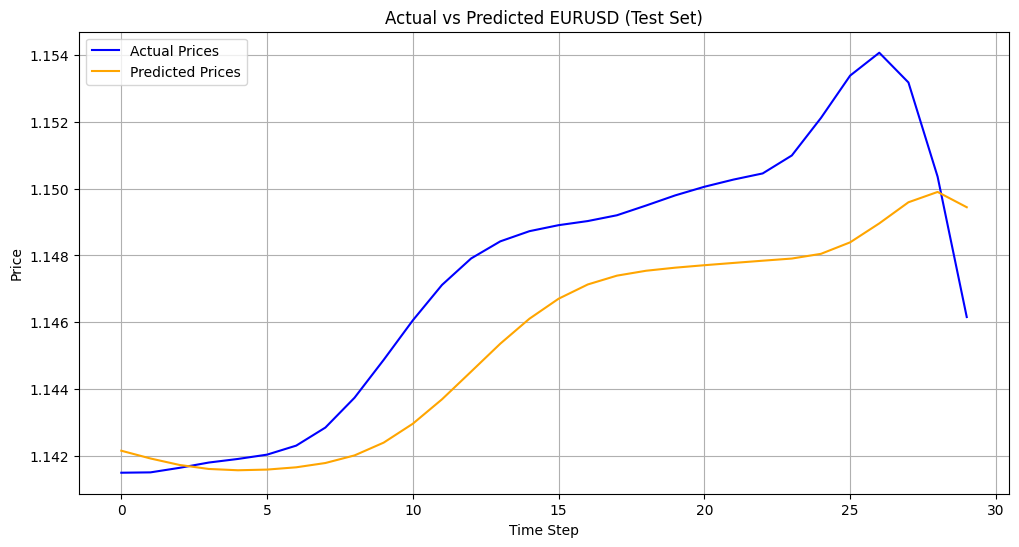

In [ ]:
# --- Print Last 3 Actual and Predicted Prices ---
print("\nLast 3 Actual Prices:", y_true[-3:].flatten())
print("Last 3 Predicted Prices:", y_pred[-3:].flatten())



Last 3 Actual Prices: [1.15318347 1.15036052 1.14615188]

Last 3 Predicted Prices: [1.1495926 1.149902  1.149444 ]